In [49]:
# https://www.kaggle.com/datasets/tombackert/brain-tumor-mri-data?select=brain-tumor-mri-dataset

import torch
from torch.utils.data import Dataset, DataLoader, random_split
from torch import nn
import os
import pathlib
from skimage.io import imread
import matplotlib.pyplot as plt

In [18]:
PATH_TO_DATA = "brain-tumor-mri-dataset"

In [40]:
class BrainTumorDataset(torch.utils.data.Dataset):
    def __init__(self, path_to_data):
        self.data = []
        self.labels = []
        for root, dirs, files in os.walk(PATH_TO_DATA):
            for file in files:
                file_path = os.path.join(root, file)
                img = imread(file_path, as_gray=True)
                self.data.append(torch.from_numpy(img))
                self.labels.append(file.split("-")[0])
                
    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        sample = self.data[idx]
        label = self.labels[idx]
        return sample, label

In [41]:
bt_data = BrainTumorDataset(PATH_TO_DATA)

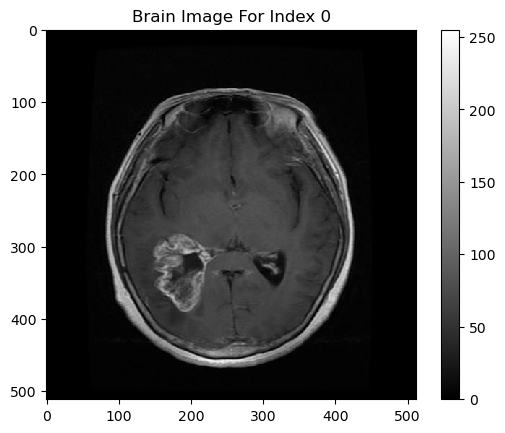

gl


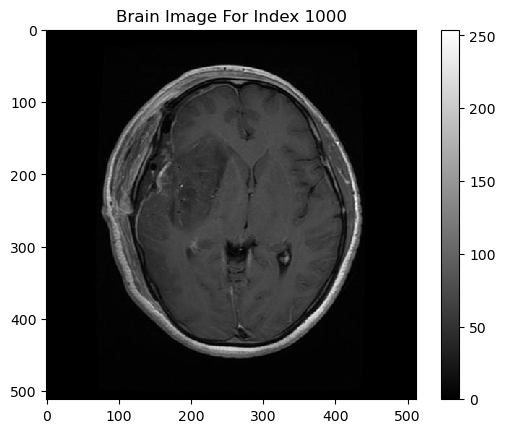

gl


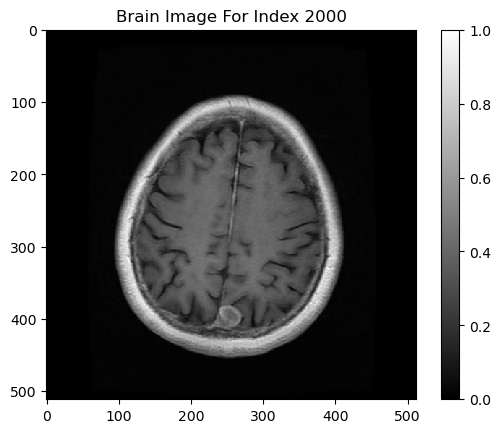

me


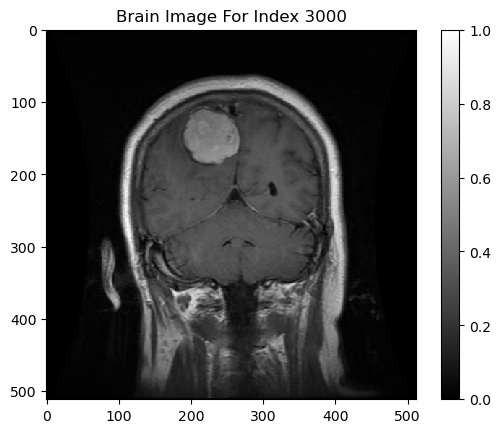

me


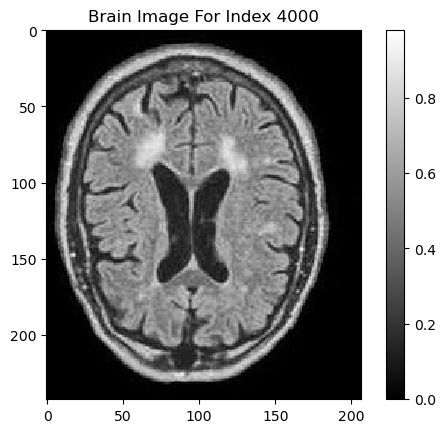

no


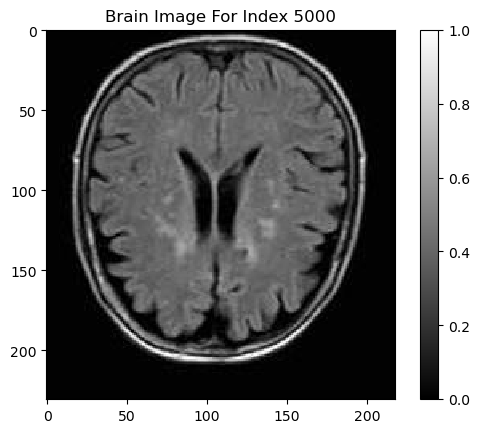

no


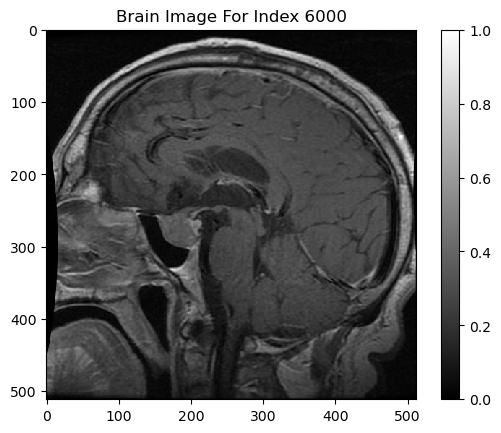

pi


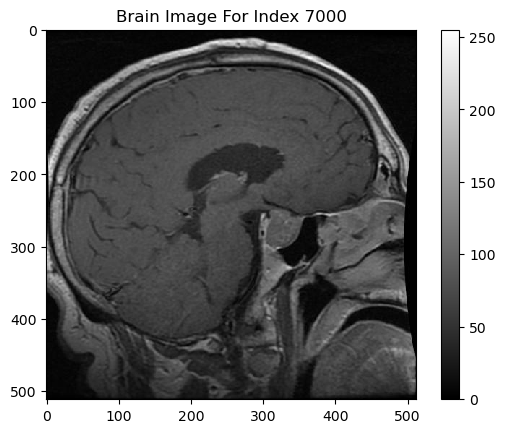

pi


In [44]:
def visualize():
    for i in range(0, len(bt_data.data), 1000):
        plt.imshow(bt_data.data[i].numpy(), cmap='gray', interpolation='nearest')
        plt.colorbar()
        plt.title('Brain Image For Index ' + str(i))
        plt.show()
        print(bt_data.labels[i])

visualize()

In [47]:
# Recommendation seems to be: 
# Use random_split if your dataset is balanced and you want simplicity.
# Use train_test_split if your dataset is imbalanced or if you need stratified splits.

train_size = int(0.8 * len(bt_data))
test_size = len(bt_data) - train_size

train_dataset, test_dataset = random_split(bt_data, [train_size, test_size], random_state=42)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

In [ ]:
# https://arxiv.org/abs/1409.1556

class VGG_16(nn.Module):
    def __init__(self):
        super().__init__()
        
        
    def forward(self, x):
        